In [78]:
%matplotlib widget
%matplotlib widget
import os
from pathlib import Path
import time
import torch
import numpy as np
import math
import gc
from functools import partial
from dataset import Dataset, load_dataframes_from_folder, reverse_normalization
from torch.utils.data import DataLoader
from transformer_zerostep import GPTConfig, GPT, warmup_cosine_lr
import argparse
import warnings
import matplotlib.pyplot as plt

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

In [79]:
# Overall settings
out_dir = "out"
batch_size = 1024

# Compute settings
cuda_device = "cuda:0"
no_cuda = False
threads = 10
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
print(torch.cuda.is_available())

True


In [80]:
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir/"ckpt_zerostep_sim_matlab_50pct_v1.pt", map_location=device)
seq_len = exp_data["cfg"].seq_len
nx = exp_data["cfg"].nx

C:\Users\39340\AppData\Local\Temp\ipykernel_33300\3824151937.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp_data = torch.load(out_dir/"ckpt_zerostep_sim_matlab_50pc

In [81]:
# Expected rmse speed
np.sqrt(exp_data['best_val_loss']) * 2500

391.94698450872085

In [82]:
# # Remove `module.` prefix from keys
# from collections import OrderedDict
# new_state_dict = OrderedDict()
# for k, v in exp_data["model"].items():
#     name = k[7:] if k.startswith("module.") else k  # Remove `module.` prefix
#     new_state_dict[name] = v

In [83]:
exp_data.keys()

dict_keys(['model', 'optimizer', 'model_args', 'iter_num', 'train_time', 'LOSS', 'LOSS_VAL', 'best_val_loss', 'cfg'])

number of parameters: 0.03M


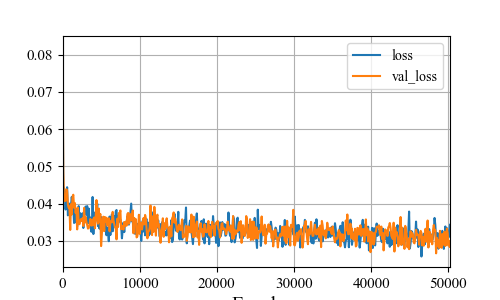

Model size in KB: 100.56640625


In [84]:
model_args = exp_data["model_args"]
gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)


state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    if k.startswith('module.'):
        state_dict[k[7:]] = v
        state_dict.pop(k)

model.load_state_dict(state_dict)

plt.figure(figsize=(5,3))
plt.plot(np.arange(exp_data['iter_num'])[::100], exp_data['LOSS'][::100], label="loss")
plt.plot(np.arange(exp_data['iter_num'])[::100], exp_data['LOSS_VAL'][::100], label="val_loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

size_in_bytes = sum(param.numel() * param.element_size() for param in model.parameters())
size_in_bytes += sum(buffer.numel() * buffer.element_size() for buffer in model.buffers())

# Convert bytes to kilobytes
size_in_kb = size_in_bytes / 1024
print('Model size in KB:', size_in_kb)

In [85]:
# folder_path = '../data/CL_experiments/test/inertia07_ki-0.0061-kp-11.8427'
# folder_path = '../data/CL_experiments/test/inertia04_ki-0.0061-kp-11.8427'
# folder_path = '../data/simulated/10_percent'
# folder_path = '../data/simulated/50_percent_longer_steps'
folder_path = '../data/CL_experiments/train/inertia13_ki-0.0061-kp-11.8427'


dfs = load_dataframes_from_folder(folder_path)
# Log the number of DataFrames loaded
print(f"Loaded {len(dfs)} DataFrames from {folder_path}.") 

# Create an instance of the dataset
dataset = Dataset(dfs=dfs, seq_len=1000)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Example of accessing an item
batch_u, batch_y = next(iter(dataloader))
batch_u, batch_y = batch_u.to(device), batch_y.to(device)
batch_y_pred = torch.empty_like(batch_y)
cputime = np.empty(batch_y.shape[1])

b, tt, _ = batch_y.shape 

Loaded 100 DataFrames from ../data/CL_experiments/train/inertia13_ki-0.0061-kp-11.8427.


In [86]:
cputime

array([6.95230599e-310, 9.04179625e-312, 6.95230599e-310, 6.95230599e-310,
       6.95230599e-310, 6.95230599e-310, 9.04179620e-312, 9.04179620e-312,
       6.95230599e-310, 9.04179620e-312, 9.04179620e-312, 9.04179621e-312,
       6.95230599e-310, 6.95230599e-310, 6.95230599e-310, 9.04179620e-312,
       6.95230599e-310, 9.04179621e-312, 6.95230599e-310, 6.95230599e-310,
       9.04179622e-312, 9.04179621e-312, 6.95230599e-310, 6.95230599e-310,
       6.95230599e-310, 6.95230599e-310, 9.04179621e-312, 9.04179626e-312,
       6.95230599e-310, 9.04179621e-312, 6.95230599e-310, 6.95230599e-310,
       6.95230599e-310, 9.04179620e-312, 6.95230599e-310, 6.95230599e-310,
       6.95230599e-310, 9.04179621e-312, 6.95230599e-310, 9.04179621e-312,
       6.95230599e-310, 9.04179621e-312, 9.04179625e-312, 9.04179621e-312,
       9.04179621e-312, 9.04179623e-312, 6.95230599e-310, 9.04179621e-312,
       6.95230599e-310, 9.04179620e-312, 9.04179621e-312, 6.95230599e-310,
       6.95230599e-310, 6

In [87]:
H = exp_data["cfg"].seq_len

with torch.no_grad():
    
    for i in range(tt):
        
        print('time instant:', i)

        # Controller u(t) = C(e(t),u(t-1))
        start = time.time()
        if i < H:
            pred = model(batch_u[:, :i+1, :])
        else:
            pred = model(batch_u[:, i-H+1:i+1, :])
        
        cputime[i] = time.time() - start
        batch_y_pred[:,i,0] = pred[:,-1,0]
        
# Reverse norm
batch_u, batch_y, batch_y_pred = reverse_normalization(batch_u, batch_y, batch_y_pred)

time instant: 0
time instant: 1
time instant: 2
time instant: 3
time instant: 4
time instant: 5
time instant: 6
time instant: 7
time instant: 8
time instant: 9
time instant: 10
time instant: 11
time instant: 12
time instant: 13
time instant: 14
time instant: 15
time instant: 16
time instant: 17
time instant: 18
time instant: 19
time instant: 20
time instant: 21
time instant: 22
time instant: 23
time instant: 24
time instant: 25
time instant: 26
time instant: 27
time instant: 28
time instant: 29
time instant: 30
time instant: 31
time instant: 32
time instant: 33
time instant: 34
time instant: 35
time instant: 36
time instant: 37
time instant: 38
time instant: 39
time instant: 40
time instant: 41
time instant: 42
time instant: 43
time instant: 44
time instant: 45
time instant: 46
time instant: 47
time instant: 48
time instant: 49
time instant: 50
time instant: 51
time instant: 52
time instant: 53
time instant: 54
time instant: 55
time instant: 56
time instant: 57
time instant: 58
time in

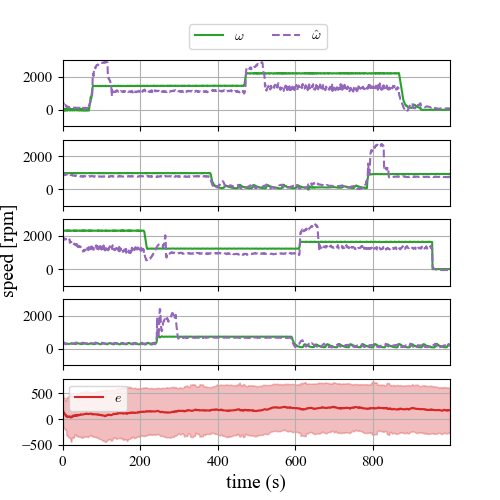

In [88]:
# Convert batch tensors to numpy for plotting
batch_y_np = batch_y.cpu().numpy()  # Shape (seq_len, 1)
batch_y_pred_np = batch_y_pred.cpu().numpy()  # Shape (seq_len, 1)

# Plotting
fig, axes = plt.subplots(5, 1, figsize=(5, 5), sharex=True)

# Plotting in each subplot
for i in range(4):
    axes[i].plot(batch_y_np[i], label=r"$\omega$", color="tab:green")
    axes[i].plot(batch_y_pred_np[i], label=r"$\hat{\omega}$", color="tab:purple", linestyle="--")
    axes[i].set_ylim([-1000, 3000])
axes[0].legend(bbox_to_anchor=(0.7, 1.65), ncols=2)

mean_error = (batch_y_np - batch_y_pred_np).mean(axis=0).flatten()
std_error = (batch_y_np - batch_y_pred_np).std(axis=0).flatten()

axes[-1].plot(mean_error, label="$e$", color="tab:red")
axes[-1].fill_between(
    np.arange(mean_error.shape[0]), 
    mean_error + std_error, 
    mean_error - std_error, 
    color='tab:red', 
    alpha=0.3
)
axes[-1].legend()

# Set the x-label for the last subplot
axes[-1].set_xlabel('time (s)')
# Add a common ylabel
fig.text(0.0, 0.5, 'speed [rpm]', va='center', rotation='vertical', fontsize=14)
# plt.savefig('prediction.pdf')
plt.show()

In [89]:
np.sqrt(mean_error**2).mean()

168.58736